In [1]:
import arviz as az
import matplotlib.pyplot as plt
import pandas as pd

import jax.numpy as jnp
from jax import random

import numpyro
from numpyro.diagnostics import hpdi, print_summary, summary
import numpyro.distributions as dist
import numpyro.optim as optim
from numpyro.infer import SVI, Trace_ELBO
from numpyro.infer.autoguide import AutoLaplaceApproximation, AutoNormal


## Qn1: 
Construct a linear regression of weight as predicted by height, using the
adults (age 18 or greater) from the Howell1 dataset. The heights listed below
were recorded in the !Kung census, but weights were not recorded for these
individuals. Provide predicted weights and 89% compatibility intervals for
each of these individuals. That is, fill in the table below, using model-based
predictions.

| Individual | height | expected weight | 89% interval |
|---|---|---|---|
|    1       | 140
|    2       | 160
|    3       | 175

In [2]:
# load data 
howell1_df = pd.read_csv('../Data/Howell1.csv', delimiter=";")
q1_df = howell1_df[howell1_df["age"] >= 18]
q1_df.head(3)

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0


#### Model 
W_i ~ Normal(mu_i, sigma)

mu_i = alpha + beta * (height_i-avg_height)

In [3]:
q1_df.describe()

,height,weight,age,male
count,352.000000,352.000000,352.000000,352.000000
mean,154.597093,44.990486,41.138494,0.468750
std,7.742332,6.456708,15.967855,0.499733
min,136.525000,31.071052,18.000000,0.000000
25%,148.590000,40.256290,28.000000,0.000000
50%,154.305000,44.792210,39.000000,0.000000
75%,160.655000,49.292693,51.000000,1.000000
max,179.070000,62.992589,88.000000,1.000000


In [4]:
xbar = q1_df.height.mean()
def model(height, weight=None):
    a = numpyro.sample("a", dist.Normal(60, 10))
    b = numpyro.sample("b", dist.LogNormal(0, 1))
    sigma = numpyro.sample("sigma", dist.Uniform(0, 10))
    mu = numpyro.deterministic("mu", a + b * (height - xbar))
    numpyro.sample("weight", dist.Normal(mu, sigma), obs=weight)

# m4_3 = AutoLaplaceApproximation(model)
m4_3 = AutoNormal(model)
svi = SVI(
    model,
    m4_3,
    optim.Adam(1),
    Trace_ELBO(),
    weight=q1_df.weight.values,
    height=q1_df.height.values,
)
svi_result = svi.run(random.PRNGKey(0), 2000)
p4_3 = svi_result.params



100%|██████████| 2000/2000 [00:01<00:00, 1762.56it/s, init loss: 149660.8906, avg. loss [1901-2000]: 1177.3358]


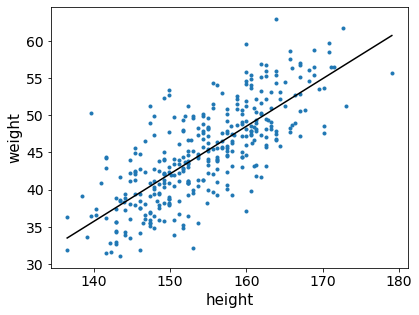

In [5]:
az.plot_pair(q1_df[["height", "weight"]].to_dict(orient="list"))
post = m4_3.sample_posterior(random.PRNGKey(1), p4_3, (1000,))
a_map = jnp.mean(post["a"])
b_map = jnp.mean(post["b"])
x = jnp.linspace(q1_df.height.min(), q1_df.height.max(), 101)
plt.plot(x, a_map + b_map * (x - xbar), "k")
plt.show()

In [6]:
post.pop("mu")
print_summary(post, 0.89, False)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
         a     45.06      0.26     45.05     44.64     45.46   1054.48      1.00
         b      0.64      0.09      0.63      0.51      0.78    984.58      1.00
     sigma      9.92      0.00      9.92      9.92      9.92    968.76      1.00



In [7]:
param_summary = summary(post, 0.89, False)
result_df = pd.DataFrame(columns = ['height', 'expected_weight','89%_interval_low','89%_interval_high'])
result_df['height'] = [140, 160, 175]
result_df['expected_weight'] = a_map + b_map * (result_df['height']  - xbar)
result_df['89%_interval_low'] = param_summary['a']['5.5%'] + param_summary['b']['5.5%'] * (result_df['height']  - xbar)
result_df['89%_interval_high'] = param_summary['a']['94.5%'] + param_summary['b']['94.5%'] * (result_df['height']  - xbar)
result_df

,height,expected_weight,89%_interval_low,89%_interval_high
0,140,35.710648,37.253097,34.010193
1,160,48.519257,47.374444,49.693253
2,175,58.125717,54.965454,61.455548


## Qn2:
From the Howell1 dataset, consider only the people younger than 13 years
old. Estimate the causal association between age and weight. Assume that
age influences weight through two paths. First, age influences height, and
height influences weight. Second, age directly influences weight through age-
related changes in muscle growth and body proportions. All of this implies
this causal model (DAG): A--> H --> W, W-->A

Use a linear regression to estimate the total (not just direct) causal effect of
each year of growth on weight. Be sure to carefully consider the priors. Try
using prior predictive simulation to assess what they imply

In [8]:
q2_df = howell1_df[howell1_df["age"] < 13]
q2_df.head(3)

,height,weight,age,male
18,121.92,19.617854,12.0,1
19,105.41,13.947954,8.0,0
20,86.36,10.489315,6.5,0


W_i ~ Normal(mu_i, sigma)

mu_i = alpha + beta * (age-avg_age)

In [9]:
q2_df.describe()

,height,weight,age,male
count,146.000000,146.000000,146.000000,146.000000
mean,98.810729,14.693328,5.401370,0.486301
std,21.489527,5.722741,3.824657,0.501533
min,53.975000,4.252425,0.000000,0.000000
25%,84.455000,10.829509,2.000000,0.000000
50%,98.844100,13.792032,5.000000,0.000000
75%,114.300000,18.335039,8.000000,1.000000
max,147.955000,32.488527,12.000000,1.000000


In [10]:

def model(age, weight=None):
    a = numpyro.sample("a", dist.Normal(15, 10))
    b = numpyro.sample("b", dist.LogNormal(0, 1))
    sigma = numpyro.sample("sigma", dist.Uniform(0, 10))
    mu = numpyro.deterministic("mu", a + b * age)
    numpyro.sample("weight", dist.Normal(mu, sigma), obs=weight)

m2 = AutoLaplaceApproximation(model)
svi = SVI(
    model,
    m2,
    optim.Adam(1),
    Trace_ELBO(),
    weight=q2_df.weight.values,
    age=q2_df.age.values,
)
svi_result = svi.run(random.PRNGKey(0), 2000)
p2 = svi_result.params


100%|██████████| 2000/2000 [00:00<00:00, 3162.78it/s, init loss: 9865.5332, avg. loss [1901-2000]: 348.4819]


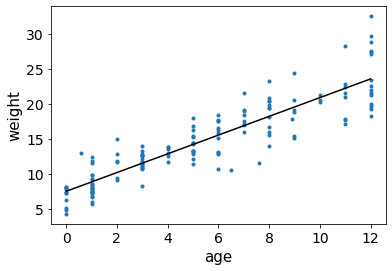

In [11]:
az.plot_pair(q2_df[["age", "weight"]].to_dict(orient="list"))
post = m2.sample_posterior(random.PRNGKey(1), p2, (1000,))
a_map = jnp.mean(post["a"])
b_map = jnp.mean(post["b"])
x = jnp.linspace(q2_df.age.min(), q2_df.age.max(), 101)
plt.plot(x, a_map + b_map * x, "k")
plt.show()

In [12]:
post.pop('mu')
print_summary(post, .89, False)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
         a      7.48      0.37      7.50      6.87      8.03    931.50      1.00
         b      1.34      0.06      1.33      1.25      1.43    910.58      1.00
     sigma      2.54      0.15      2.53      2.31      2.79    949.35      1.00



## Qn3: 
Now suppose the causal association between age and weight might be different for boys and girls. 
Use a single linear regression, with a categorical
variable for sex, to estimate the total causal effect of age on weight separately
for boys and girls. How do girls and boys differ? Provide one or more posterior contrasts as a summary.

In [13]:
male_df = q2_df[q2_df["male"] ==1]
female_df = q2_df[q2_df["male"] ==0]

In [14]:
male_df.describe()

,height,weight,age,male
count,71.000000,71.000000,71.000000,71.0
mean,101.156817,15.516631,5.494366,1.0
std,21.107285,5.922350,3.815341,0.0
min,60.452000,5.669900,0.000000,1.0
25%,84.772500,11.467373,2.000000,1.0
50%,100.965000,14.401546,5.000000,1.0
75%,115.267500,19.050864,8.000000,1.0
max,147.955000,32.488527,12.000000,1.0


In [15]:
female_df.describe()

,height,weight,age,male
count,75.000000,75.000000,75.000000,75.0
mean,96.589765,13.913935,5.313333,0.0
std,21.752290,5.452293,3.857052,0.0
min,53.975000,4.252425,0.000000,0.0
25%,82.702400,9.851451,2.000000,0.0
50%,97.155000,13.267566,5.000000,0.0
75%,111.125000,17.364069,8.000000,0.0
max,146.050000,29.596878,12.000000,0.0


In [16]:
x_bar = male_df.age.mean()
mm = AutoLaplaceApproximation(model)
svi = SVI(
    model,
    mm,
    optim.Adam(1),
    Trace_ELBO(),
    weight=male_df.weight.values,
    age=male_df.age.values,
)
svi_result = svi.run(random.PRNGKey(0), 2000)
pmm = svi_result.params


100%|██████████| 2000/2000 [00:00<00:00, 3429.88it/s, init loss: 4654.1885, avg. loss [1901-2000]: 175.4143]


In [17]:
mf = AutoLaplaceApproximation(model)
svi = SVI(
    model,
    mf,
    optim.Adam(1),
    Trace_ELBO(),
    weight=female_df.weight.values,
    age=female_df.age.values,
)
svi_result = svi.run(random.PRNGKey(0), 2000)
pmf = svi_result.params



100%|██████████| 2000/2000 [00:00<00:00, 3475.60it/s, init loss: 5219.9219, avg. loss [1901-2000]: 172.2580]


boys

                mean       std    median      5.5%     94.5%     n_eff     r_hat
         a      7.95      0.56      7.97      7.03      8.79    931.50      1.00
         b      1.38      0.08      1.38      1.25      1.52    912.62      1.00
     sigma      2.65      0.23      2.64      2.31      3.03    948.91      1.00

girls

                mean       std    median      5.5%     94.5%     n_eff     r_hat
         a      7.11      0.44      7.12      6.37      7.77    931.50      1.00
         b      1.29      0.07      1.28      1.18      1.39    906.51      1.00
     sigma      2.23      0.18      2.23      1.96      2.55    948.97      1.00



<Figure size 432x288 with 0 Axes>

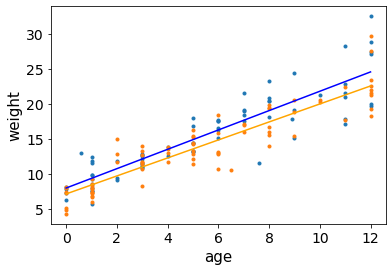

In [18]:
from turtle import color


plt.figure()
ax1= az.plot_pair(male_df[["age", "weight"]].to_dict(orient="list"))
post = mm.sample_posterior(random.PRNGKey(1), pmm, (1000,))
post.pop("mu")
print('boys')
print_summary(post, 0.89, False)
a_map = jnp.mean(post["a"])
b_map = jnp.mean(post["b"])
x = jnp.linspace(male_df.age.min(), male_df.age.max(), 101)
plt.plot(x, a_map + b_map * x, "b")

az.plot_pair(female_df[["age", "weight"]].to_dict(orient="list"), ax = ax1)
post = mf.sample_posterior(random.PRNGKey(1), pmf, (1000,))
print("girls")
post.pop("mu")
print_summary(post, 0.89, False)
a_map = jnp.mean(post["a"])
b_map = jnp.mean(post["b"])
x = jnp.linspace(female_df.age.min(), female_df.age.max(), 101)
plt.plot(x, a_map + b_map * x, "orange")
plt.show()

In [24]:
svi_result

SVIRunResult(params={'auto_loc': DeviceArray([13.918523  , 15.514325  ,  0.25777417], dtype=float32)}, state=SVIState(optim_state=(DeviceArray(2000, dtype=int32, weak_type=True), OptimizerState(packed_state=([DeviceArray([13.918523  , 15.514325  ,  0.25777417], dtype=float32), DeviceArray([4.3001901e-08, 2.2631173e-07, 6.3004395e-06], dtype=float32), DeviceArray([0.13487418, 0.11363288, 2.7819638 ], dtype=float32)],), tree_def=PyTreeDef({'auto_loc': *}), subtree_defs=(PyTreeDef((*, *, *)),))), mutable_state=None, rng_key=DeviceArray([2238448716, 3297768858], dtype=uint32)), losses=DeviceArray([711.1869 , 657.43866, 630.46173, ..., 467.75134, 467.75137,
             467.7514 ], dtype=float32))

In [40]:
### How to do this for each age?? 

def model(sex, weight):
    a = numpyro.sample("a", dist.Normal(15, 10).expand([len(set(sex))]))
    sigma = numpyro.sample("sigma", dist.Uniform(0, 10))
    mu = a[sex]
    numpyro.sample("weight", dist.Normal(mu, sigma), obs=weight)


m3 = AutoLaplaceApproximation(model)
svi = SVI(
    model, m3, optim.Adam(1), Trace_ELBO(), 
    sex=q2_df.male.values,  
    weight=q2_df.weight.values
)
svi_result = svi.run(random.PRNGKey(0), 2000)
p3 = svi_result.params
post = m3.sample_posterior(random.PRNGKey(1), p3, (1000,))
print_summary(post, 0.89, False)

100%|██████████| 2000/2000 [00:00<00:00, 3684.76it/s, init loss: 711.1869, avg. loss [1901-2000]: 467.7511]



                mean       std    median      5.5%     94.5%     n_eff     r_hat
      a[0]     13.96      0.66     13.98     12.87     14.95    931.50      1.00
      a[1]     15.51      0.68     15.50     14.51     16.67   1111.41      1.00
     sigma      5.64      0.33      5.65      5.13      6.19    950.14      1.00



In [41]:
# boys minus girls 
post["diff_fm"] =  post["a"][:, 1] - post["a"][:, 0]
print_summary(post, 0.89, False)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
      a[0]     13.96      0.66     13.98     12.87     14.95    931.50      1.00
      a[1]     15.51      0.68     15.50     14.51     16.67   1111.41      1.00
   diff_fm      1.54      0.95      1.51      0.17      3.14    877.87      1.00
     sigma      5.64      0.33      5.65      5.13      6.19    950.14      1.00



(array([  7.,   5.,  42., 114., 218., 244., 196., 117.,  45.,  12.]),
 array([-1.788454  , -1.181268  , -0.5740818 ,  0.03310432,  0.64029044,
         1.2474766 ,  1.8546627 ,  2.4618487 ,  3.069035  ,  3.6762211 ,
         4.283407  ], dtype=float32),
 <BarContainer object of 10 artists>)

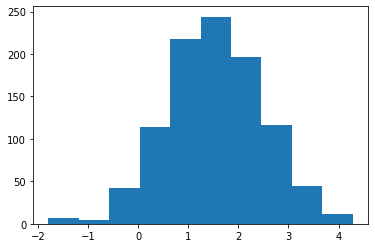

In [43]:
plt.hist(post["diff_fm"])